<img src="https://raw.githubusercontent.com/Helgone/ProForQ/master/title.png" alt="Girl in a jacket" width="2000" height="500">
    
    

<font size="5">****Final Project****</font> <br> 

 <br> 
<font size="4">****Motivation****</font> <br>  


This project is developed with the Python Programming Language and it has been created throughout the course

 <br>
<center><b> 4,796: Skills: Programming for Quantitative Analysis, Sping Semester 2021, HSG</b>. </center>
 

The whole project is in the open document format of a Jupyter Notebook, and it's complemented by a [companion website](https://helgone.github.io/ProForQ/). 


The focus of this project is the application of statistical methods to economic data in order to give empirical content to economic relationships. This is the definition of Econometrics, as given by [The New Palgrave Dictionary of Economics](https://link.springer.com/referencework/10.1057/978-1-349-95121-5#introduction). In particular, we focus on such applications in the fied of labor markets. The relationships we investigate are for example:

- wages and total hours worked
- wages and effort per hour
- wages and full time employment 
- years of education and wages

Our aim is to investigate and quantify to which extent there is a relationship between such variables, and eventually claim that such relationsips are causal. 

 <br> 

<font size="4">****Introduction to Impact Evaluation****</font> <br> 

Within the Rubin Causal Model, a causal effect (of a treatment/program) is defined as the difference between the potential outcome with and without the treatment. The *fundamental problem of causal inference* ([Holland, 1986](https://www.jstor.org/stable/2289064?seq=1#metadata_info_tab_contents)) is that at most one of the potential outcomes can be realized, and thus observed. A possible solution is to "mimic" or construct the counterfactual, with the goal of attributing any differences in outcomes between the group of participants and the conterfactual group to the program rather than to other factors.

Methods for doing this are numerous, and can be mainly divided in two categories:

- **Randomized Experiments**
     - Use random assignment of the program to create a control group which mimics the counterfactual

- **Non- or Quasi-Experimental Methods**
     - Argue that a certain excluded group mimics the counterfactual
        - Pre-Post
        - Simple Difference
        - Differences-in-Differences
        - Instrumental Variables
        - Regression Discontinuity




<font size="5">****Table of Contents****</font>  

1. [Introduction to Impact Evaluation](#introduction)


2. [Technical Set-Up](#setup)


3. [Randomized Field Experiments](#RCT)  



4. [Difference in Differences](#DinD)  
&nbsp;&nbsp;&nbsp;4.1 [Theory](#theory1)  
&nbsp;&nbsp;&nbsp;4.2 [Example](#example1)



5. [Regression Discontinuity](#RDD)  
&nbsp;&nbsp;&nbsp;5.1 [Theory](#theory2)  
&nbsp;&nbsp;&nbsp;5.2 [Example](#example2)  




6. [Instrumental Variables](#IV)  
&nbsp;&nbsp;&nbsp;6.1 [Theory](#theory3)  
&nbsp;&nbsp;&nbsp;6.2 [Example](#example3) <br/>
&nbsp;&nbsp;&nbsp;6.3 [Simulation](#simulation) 



7. [Limitations of RCTs](#limitations)  



8. [Conclusion and discussion](#conclusion_and_discussion)

<font size="5">****2&nbsp;&nbsp; Technical Set-Up****</font>

As stated at the beginning of this document, this project is done with the Python programming language. Moreover, this should be a programming project more than a theoretical project.


As a first thing, we import the libraries we will use:

In [1]:
# pip install tabulate
# pip install FixedEffectModel
# pip install category_encoders
# pip install -U seaborn

# pip install dash==1.20.0
# pip install jupyter-dash

In [2]:
import category_encoders as cat_encoder
import FixedEffectModel.api as FEM
from   linearmodels import PanelOLS
from   linearmodels.iv import IV2SLS
from   linearmodels.panel import PanelOLS
import numpy                   as np
import math
import matplotlib
import matplotlib.pyplot       as plt
from   matplotlib.pyplot import figure
import os
import pandas                  as pd
import random
from   scipy import stats
import seaborn as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from   statsmodels.iolib.summary2 import summary_col
from   tabulate import tabulate



matplotlib.rcParams["figure.figsize"] = [12.0 , 6.0] 

As a second thing, we set the current working directory, in order to know in which environment are we in right now. This will be useful when we will import the data.

In [3]:
os. chdir(os.getcwd())
print("Current working directory is: {}".format(os.getcwd()))


#os. chdir(os.getcwd() + "/data")

Current working directory is: /Users/andreasalem/Pyth1/QProg/Final_Project


<font size="5">****3&nbsp;&nbsp; Randomized  Field  Experiments: An Empirical Method to Make Causal Claims****</font>


<br>
<br>


<div style="text-align:center">
<img src="https://raw.githubusercontent.com/Helgone/ProForQ/master/Linear_Regressiom.png" title="Anatomy of a Matplotlib figure" class="center" width="250">
</div>


<br>
<br>



The academic paper which results we will replicate is: 

**Fehr, Ernst, and Lorenz Goette. 2007. "Do Workers Work More if Wages Are High? Evidence from a Randomized Field Experiment." *American Economic Review*, 97 (1): 298-317.**

The goal of this section, is to introduce RCTs with an example. The design of the experiment allowed to separate between a treatment and a control group. This identification is exploited to estimate a treatment effect. Finally, the treatment effect is used to compute the initertemporal elasticity of labor with respect to wage. Thus, this is a good example of how from an impact evaluation useful conclusions for policy can be drawn.  

This section is divided as follows:
- **3.1** Check characteristics of the two groups at baseline. They should be identical
- **3.2** Estimate the treatment effect
   - Estiamte all 6 models as in the paper
   - Include fixed effects
   - Compute clustered standard error
- **3.3** Compute intertemporal elasticity of substitution with regard to labor supply
    -  Explain why might effort per hour decrease

<font size="3">****3.1&nbsp;&nbsp; Baseline Characteristics****</font>

The messengers present in the data either participated in the experiment or did not participate. The messenger who participated were either assigned to the treatment group or to the control group (and then switched roles). 

The variable `block` takes value:
- 1 for the period pre-experiment
- 2 for period in which group A (odd) were the experimental treatment group and B the control
- 3 for period in which groups A and B switched roles

Here we compute baseline characteristics for participating messengers only. 

In [4]:
data = pd.read_csv("data/Fehr_Goette_AER_2007_data.csv")

In [5]:
print(data.columns)

Index(['vebli', 'block', 'totrev', 'shifts', 'treatment', 'maxhigh',
       'shifts_fe', 'totrev_fe', 'experiment', 'odd', 'fahrer'],
      dtype='object')


In [6]:
odd_rev = round(data[(data["odd"] == 1) & (data["block"] == 1)]["totrev"].dropna().mean(),3) # A (odd)
even_rev = round(data[(data["odd"] == 0) & (data["block"] == 1)]["totrev"].dropna().mean(),3) # B (even)

odd_shift = round(data[(data["odd"] == 1) & (data["block"] == 1)]["shifts"].dropna().mean(),2) # A (odd)
even_shift = round(data[(data["odd"] == 0) & (data["block"] == 1)]["shifts"].dropna().mean(),2) # B (even)

In [7]:
table = {'': ['mean revenues', 'mean shifts'], 'Group A (odd ID)': [odd_rev, odd_shift], 'Group B (even ID)': [even_rev, even_shift]}      

print(tabulate(table, headers='keys'))




                 Group A (odd ID)    Group B (even ID)
-------------  ------------------  -------------------
mean revenues             3500.67              3258.99
mean shifts                 12.14                10.95


Are these differences statistical significant? In theory they should not! Otherwise groups are not ex-ante identical on average.

In [8]:
data['constant'] = 1 # create a constate to estiamte the intercept coefficient of the OLS regression

data_block1 = data[data['block'] == 1].dropna() # we select only observations from the first block (i.e., the pre-experiment period) and exlucde NAs (i.e., messengers not participatin in the experiment)           

X = data_block1[["constant","odd"]]

#### Dependent Variable: Total Revenues ("totrev")
y = data_block1["totrev"]


model_1 = sm.OLS(endog = y, 
                 exog = X)

# alternative way, using R-style formulas, calling "statsmodels.formula.api"
#model_1 = smf.ols(formula='totrev ~ odd', data=data_block1) # note: we don't need to insert the constant term manually. In addition, NAs values form the dataset selected would be automatically removed


#### Dependent Variable: Number of shifts ("shifts")
X = data_block1[["constant","odd"]]
y = data_block1["shifts"]


model_2 = sm.OLS(endog = y, 
                 exog = X)

# alternative way
#model_2 = smf.ols(formula='totrev ~ odd', data=data_block1)

# Summarize results

results_1 = model_1.fit()
results_2 = model_2.fit()

print(summary_col([results_1, results_2],stars=True))




             totrev      shifts  
---------------------------------
constant  3258.9947*** 10.9474***
          (580.1298)   (1.7978)  
odd       241.6719     1.1955    
          (800.6552)   (2.4812)  
R-squared -0.0239      -0.0201   
          0.0024       0.0061    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Both coefficients are not statistical different from 0: dividing each estimated coefficient by his
corresponding standard error yields very low t-statistics, which means that the hypothesis that the
true coefficient doesn’t depart much from having value 0 is likely to be true.

In other words, Group A and Group B generate very similar revenues per messenger during the
four weeks prior to the experiment, and work also the same number of shifts on average. Thus,
in the absence of an experimental treatment, the messengers who participated in the experiment
(Group A and Group B) behave in the same way. The randomization between treatment and control
groups was successful!




<font size="3">****3.2&nbsp;&nbsp; Treatment Effects****</font>

In [9]:
data['period_1'] = np.where(data["block"] == 2, 1, 0)
data['period_2'] = np.where(data["block"] == 3, 1, 0)

**METHOD 1 (still without clustering se at individual level)**

In [10]:
#ciao =  pd.Series(data_1["fahrer"], dtype="category")

data_fe = pd.get_dummies(data,
             columns = ["fahrer"]) # we factorise the variable "fahrer". This will be helpful to account for individual  fixed-effects   

# if we run this cell more than once, we will get an error because of repeating "get_dummies" command


In [11]:
data_1 = data_fe[data_fe["maxhigh"] == 1] # data for columns 1 and 4 (only participating messengers at Veloblitz, i.e., groups A and B)          
data_2 = data_fe[data_fe["vebli"] == 1] # data for columns 2 and 5 (all messengers at Veloblitz)

In [12]:
data_1 = data_1.loc[:, (data_1 != 0).any(axis=0)] # we eliminate all the columns with only 0s
data_2 = data_2.loc[:, (data_2 != 0).any(axis=0)] # we eliminate all the columns with only 0s

In [13]:
{data_1.columns.get_loc(c): c for idx, c in enumerate(data_1.columns)} # useful

{0: 'vebli',
 1: 'block',
 2: 'totrev',
 3: 'shifts',
 4: 'treatment',
 5: 'maxhigh',
 6: 'shifts_fe',
 7: 'totrev_fe',
 8: 'experiment',
 9: 'odd',
 10: 'constant',
 11: 'period_1',
 12: 'period_2',
 13: 'fahrer_1',
 14: 'fahrer_2',
 15: 'fahrer_3',
 16: 'fahrer_5',
 17: 'fahrer_6',
 18: 'fahrer_7',
 19: 'fahrer_8',
 20: 'fahrer_9',
 21: 'fahrer_14',
 22: 'fahrer_15',
 23: 'fahrer_18',
 24: 'fahrer_19',
 25: 'fahrer_21',
 26: 'fahrer_22',
 27: 'fahrer_23',
 28: 'fahrer_24',
 29: 'fahrer_25',
 30: 'fahrer_28',
 31: 'fahrer_30',
 32: 'fahrer_31',
 33: 'fahrer_32',
 34: 'fahrer_33',
 35: 'fahrer_34',
 36: 'fahrer_35',
 37: 'fahrer_36',
 38: 'fahrer_37',
 39: 'fahrer_38',
 40: 'fahrer_42',
 41: 'fahrer_44',
 42: 'fahrer_45',
 43: 'fahrer_49',
 44: 'fahrer_50',
 45: 'fahrer_51',
 46: 'fahrer_52',
 47: 'fahrer_53',
 48: 'fahrer_55',
 49: 'fahrer_56',
 50: 'fahrer_57',
 51: 'fahrer_58',
 52: 'fahrer_60',
 53: 'fahrer_61',
 54: 'fahrer_63'}

In [14]:
#exog_vars = ["treatment", "period_1", "period_2", "fahrer"] # we didn't use the column "constant"
#X = sm.add_constant(data[exog_vars])


fe = data_1.iloc[:, 14:55] # control for messenger specific fixed-effects (we remove fahrer_1)
X = data_1[["constant", "treatment", "period_1", "period_2"]]
X = pd.concat([X, fe], axis=1)
y = data_1["totrev"]


ols1 = sm.OLS(endog = y,
              exog = X)

In [15]:
results1 = ols1.fit()



#print(summary_col([results1],stars=True))


# regressors = ["treatment", "period_1", "period_2"]
tble = summary_col(results1, stars = True) #, regressor_order=regressors)

tble.tables[0] = tble.tables[0][:8] # we don't print the coefficients for all "fahrer"
print(tble)



             totrev   
----------------------
constant  1611.6750*  
          (911.7985)  
treatment 1033.5600***
          (336.7039)  
period_1  -210.9725   
          (385.3052)  
period_2  -574.7125   
          (378.2348)  
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


**METHOD 2, more elegant (still without clustering se at individual level)**

In [16]:
data_11 = data[data["maxhigh"] == 1]


fahrer_fe_ols = smf.ols(formula=" totrev ~ treatment + period_1 + period_2 + C(fahrer)", data=data_11).fit(use_t=True) # intercept already included


fahrer_fe_ols.summary()

# we get same coefficients and same SEs

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 totrev   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     5.121
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           1.60e-10
Time:                        15:13:46   Log-Likelihood:                -1058.2
No. Observations:                 124   AIC:                             2206.
Df Residuals:                      79   BIC:                             2333.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1611.6750    911.798      1.768      0.081    -203.214    3426.564
C(fahrer)[T.2]    436.7000   1258.401      0.347      0.729   -2068.085    2941.485
C(fahrer)[T.3]    747.2000   1258.401      0.594      0.554   -1757.585    3251.985
C(fahrer)[T.5]  -1270.4125   1410.449     -0.901      0.370   -4077.840    1537.015
C(fahrer)[T.6]   1537.5000   1258.401      1.222      0.225    -967.285    4042.285
C(fahrer)[T.7]    750.1667   1258.401      0.596      0.553   -1754.619    3254.952
C(fahrer)[T.8]   -106.9667   1258.401     -0.085      0.932   -2611.752    2397.819
C(fahrer)[T.9]   3912.2000   1258.401      3.109      0.003    1407.415    6416.985
C(fahrer)[T.14]   884.0000   1258.401      0.702      0.484   -1620.785    3388.785
C(fahrer)[T.15]   -39.9667   1258.401     -0.032      0.975   -2544.752    2464.819
C(fahrer)[T.18]  1327.3667   1258.401      1.055      0.295   -1177.419    3832.152
C(fahrer)[T.19]  2658.9667   1258.401      2.113      0.038     154.181    5163.752
C(fahrer)[T.21]  -514.1333   1258.401     -0.409      0.684   -3018.919    1990.652
C(fahrer)[T.22]  2955.6000   1258.401      2.349      0.021     450.815    5460.385
C(fahrer)[T.23]  3330.2333   1258.401      2.646      0.010     825.448    5835.019
C(fahrer)[T.24]  1759.1667   1258.401      1.398      0.166    -745.619    4263.952
C(fahrer)[T.25]    61.1667   1258.401      0.049      0.961   -2443.619    2565.952
C(fahrer)[T.28]  -150.1667   1258.401     -0.119      0.905   -2654.952    2354.619
C(fahrer)[T.30]  1557.5333   1258.401      1.238      0.219    -947.252    4062.319
C(fahrer)[T.31]  -737.9667   1258.401     -0.586      0.559   -3242.752    1766.819
C(fahrer)[T.32]  -526.1000   1258.401     -0.418      0.677   -3030.885    1978.685
C(fahrer)[T.33]  2173.2000   1258.401      1.727      0.088    -331.585    4677.985
C(fahrer)[T.34]  9107.0333   1258.401      7.237      0.000    6602.248    1.16e+04
C(fahrer)[T.35]   -64.0000   1258.401     -0.051      0.960   -2568.785    2440.785
C(fahrer)[T.36]  2054.9000   1258.401      1.633      0.106    -449.885    4559.685
C(fahrer)[T.37]  2193.9667   1258.401      1.743      0.085    -310.819    4698.752
C(fahrer)[T.38]  1836.9333   1258.401      1.460      0.148    -667.852    4341.719
C(fahrer)[T.42]  3938.0333   1258.401      3.129      0.002    1433.248    6442.819
C(fahrer)[T.44]   521.8667   1258.401      0.415      0.679   -1982.919    3026.652
C(fahrer)[T.45]   569.7667   1258.401      0.453      0.652   -1935.019    3074.552
C(fahrer)[T.49]  1044.2000   1258.401      0.830      0.409   -1460.585    3548.985
C(fahrer)[T.50]  6590.6667   1258.401      5.237      0.000    4085.881    9095.452
C(fahrer)[T.51]  5288.9667   1258.401      4.203      0.000    2784.181    7793.752
C(fahrer)[T.52]  4278.3000   1258.401      3.400      0.001

In [17]:
# We now compute SEs clustered at the individual level

column1 = smf.ols(formula=" totrev ~ treatment + period_1 + period_2 + C(fahrer)", data=data_11).fit(
    cov_type='cluster',
              cov_kwds={'groups': data_11["fahrer"]},use_t=True) 

column1.summary() # the results match the table at pag. 309 of the original paper! 


/Users/andreasalem/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 44, but rank is 3
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 totrev   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     7.244
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           0.000522
Time:                        15:13:46   Log-Likelihood:                -1058.2
No. Observations:                 124   AIC:                             2206.
Df Residuals:                      79   BIC:                             2333.
Df Model:                          44                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1611.6750    292.968      5.501      0.000    1020.014    2203.336
C(fahrer)[T.2]    436.7000    1.8e-11   2.43e+13      0.000     436.700     436.700
C(fahrer)[T.3]    747.2000   1.82e-11   4.11e+13      0.000     747.200     747.200
C(fahrer)[T.5]  -1270.4125    146.484     -8.673      0.000   -1566.243    -974.582
C(fahrer)[T.6]   1537.5000   1.99e-11   7.72e+13      0.000    1537.500    1537.500
C(fahrer)[T.7]    750.1667    1.8e-11   4.16e+13      0.000     750.167     750.167
C(fahrer)[T.8]   -106.9667   1.86e-11  -5.75e+12      0.000    -106.967    -106.967
C(fahrer)[T.9]   3912.2000    1.8e-11   2.18e+14      0.000    3912.200    3912.200
C(fahrer)[T.14]   884.0000   1.81e-11    4.9e+13      0.000     884.000     884.000
C(fahrer)[T.15]   -39.9667    1.9e-11   -2.1e+12      0.000     -39.967     -39.967
C(fahrer)[T.18]  1327.3667   1.84e-11   7.21e+13      0.000    1327.367    1327.367
C(fahrer)[T.19]  2658.9667   2.51e-11   1.06e+14      0.000    2658.967    2658.967
C(fahrer)[T.21]  -514.1333   1.97e-11  -2.61e+13      0.000    -514.133    -514.133
C(fahrer)[T.22]  2955.6000   1.85e-11    1.6e+14      0.000    2955.600    2955.600
C(fahrer)[T.23]  3330.2333   1.81e-11   1.84e+14      0.000    3330.233    3330.233
C(fahrer)[T.24]  1759.1667   1.94e-11   9.05e+13      0.000    1759.167    1759.167
C(fahrer)[T.25]    61.1667    1.8e-11    3.4e+12      0.000      61.167      61.167
C(fahrer)[T.28]  -150.1667   2.28e-11  -6.58e+12      0.000    -150.167    -150.167
C(fahrer)[T.30]  1557.5333   1.78e-11   8.74e+13      0.000    1557.533    1557.533
C(fahrer)[T.31]  -737.9667   1.78e-11  -4.15e+13      0.000    -737.967    -737.967
C(fahrer)[T.32]  -526.1000   2.05e-11  -2.57e+13      0.000    -526.100    -526.100
C(fahrer)[T.33]  2173.2000   1.75e-11   1.24e+14      0.000    2173.200    2173.200
C(fahrer)[T.34]  9107.0333   1.82e-11   4.99e+14      0.000    9107.033    9107.033
C(fahrer)[T.35]   -64.0000    1.9e-11  -3.37e+12      0.000     -64.000     -64.000
C(fahrer)[T.36]  2054.9000   1.83e-11   1.12e+14      0.000    2054.900    2054.900
C(fahrer)[T.37]  2193.9667      2e-11    1.1e+14      0.000    2193.967    2193.967
C(fahrer)[T.38]  1836.9333   1.94e-11   9.46e+13      0.000    1836.933    1836.933
C(fahrer)[T.42]  3938.0333    1.7e-11   2.32e+14      0.000    3938.033    3938.033
C(fahrer)[T.44]   521.8667   1.79e-11   2.91e+13      0.000     521.867     521.867
C(fahrer)[T.45]   569.7667   1.81e-11   3.15e+13      0.000     569.767     569.767
C(fahrer)[T.49]  1044.2000   2.07e-11   5.05e+13      0.000    1044.200    1044.200
C(fahrer)[T.50]  6590.6667   1.74e-11   3.78e+14      0.000    6590.667    6590.667
C(fahrer)[T.51]  5288.9667   2.42e-11   2.19e+14      0.000    5288.967    5288.967
C(fahrer)[T.52]  4278.3000   1.82e-11   2.35e+14      0.000

We jsut did column 1. Column 4 is exactly the same, but with another dependent variable: number of shifts instead of total revenue. 
Before applying the same procedure to the other dependent variable, we first replicate columns 2 and 3 (using method 2, more elegant).

In [18]:
# Column 2

data_2 = data[data["vebli"] == 1]

column2 = smf.ols(formula=" totrev ~ treatment + period_1 + period_2 + C(fahrer)", data=data_2).fit(
    cov_type='cluster',
              cov_kwds={'groups': data_2["fahrer"]},use_t=True) 

column2.summary() # the results match the table at pag. 309 of the original paper! 


/Users/andreasalem/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 68, but rank is 3
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 totrev   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     6.169
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           0.000935
Time:                        15:13:46   Log-Likelihood:                -1598.2
No. Observations:                 190   AIC:                             3334.
Df Residuals:                     121   BIC:                             3559.
Df Model:                          68                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1671.7518    209.868      7.966      0.000    1252.616    2090.887
C(fahrer)[T.2]    436.7000   1.49e-10   2.92e+12      0.000     436.700     436.700
C(fahrer)[T.3]    747.2000   1.49e-10      5e+12      0.000     747.200     747.200
C(fahrer)[T.4]   -660.3012     99.281     -6.651      0.000    -858.580    -462.023
C(fahrer)[T.5]  -1240.3741    104.934    -11.821      0.000   -1449.942   -1030.806
C(fahrer)[T.6]   1537.5000   1.49e-10   1.03e+13      0.000    1537.500    1537.500
C(fahrer)[T.7]    750.1667   1.49e-10   5.04e+12      0.000     750.167     750.167
C(fahrer)[T.8]   -106.9667   1.49e-10  -7.16e+11      0.000    -106.967    -106.967
C(fahrer)[T.9]   3912.2000   1.49e-10   2.62e+13      0.000    3912.200    3912.200
C(fahrer)[T.10]  -811.6346     99.281     -8.175      0.000   -1009.913    -613.356
C(fahrer)[T.11]  2942.1988     99.281     29.635      0.000    2743.920    3140.477
C(fahrer)[T.12] -1222.4679     99.281    -12.313      0.000   -1420.746   -1024.190
C(fahrer)[T.13]  -959.8012     99.281     -9.667      0.000   -1158.080    -761.523
C(fahrer)[T.14]   884.0000   1.49e-10   5.92e+12      0.000     884.000     884.000
C(fahrer)[T.15]   -39.9667   1.49e-10  -2.67e+11      0.000     -39.967     -39.967
C(fahrer)[T.16]   197.8321     99.281      1.993      0.051      -0.446     396.110
C(fahrer)[T.17]  -463.8012     99.281     -4.672      0.000    -662.080    -265.523
C(fahrer)[T.18]  1327.3667   1.51e-10   8.81e+12      0.000    1327.367    1327.367
C(fahrer)[T.19]  2658.9667   1.51e-10   1.76e+13      0.000    2658.967    2658.967
C(fahrer)[T.20]  -720.1679     99.281     -7.254      0.000    -918.446    -521.890
C(fahrer)[T.21]  -514.1333   1.51e-10   -3.4e+12      0.000    -514.133    -514.133
C(fahrer)[T.22]  2955.6000   1.49e-10   1.98e+13      0.000    2955.600    2955.600
C(fahrer)[T.23]  3330.2333   1.49e-10   2.23e+13      0.000    3330.233    3330.233
C(fahrer)[T.24]  1759.1667   1.53e-10   1.15e+13      0.000    1759.167    1759.167
C(fahrer)[T.25]    61.1667    1.5e-10   4.07e+11      0.000      61.167      61.167
C(fahrer)[T.26]  -259.6346     99.281     -2.615      0.011    -457.913     -61.356
C(fahrer)[T.27]  -573.1679     99.281     -5.773      0.000    -771.446    -374.890
C(fahrer)[T.28]  -150.1667    1.5e-10     -1e+12      0.000    -150.167    -150.167
C(fahrer)[T.29] -1042.1346     99.281    -10.497      0.000   -1240.413    -843.856
C(fahrer)[T.30]  1557.5333    1.5e-10   1.04e+13      0.000    1557.533    1557.533
C(fahrer)[T.31]  -737.9667    1.5e-10  -4.94e+12      0.000    -737.967    -737.967
C(fahrer)[T.32]  -526.1000   1.49e-10  -3.52e+12      0.000    -526.100    -526.100
C(fahrer)[T.33]  2173.2000    1.5e-10   1.45e+13      0.000    2173.200    2173.200
C(fahrer)[T.34]  9107.0333   1.48e-10   6.14e+13      0.000

In [19]:
# Column 3


column3 = smf.ols(formula=" totrev ~ treatment + experiment + period_1 + period_2 + C(fahrer)", data=data).fit(
    cov_type='cluster',
              cov_kwds={'groups': data["fahrer"]},use_t=True) 

column3.summary() # to get the right coefficient for the dummy "treatment" (effect of the treatment comparing treatment group only to Flash messenger), we need to add the coefficients for "treatment" and "experiment": 1090.20 + (-54.40) = 1035.8 (CHF)

regressors = ["treatment", "experiment", "period_1", "period_2"]
tble = summary_col([column1,column2, column3],stars=True, regressor_order=regressors)


tble.tables[0] = tble.tables[0][:8] # we don't print the coefficients for all "fahrer"

print(tble)

# we will show this table in a nicer way in the companion website

/Users/andreasalem/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 141, but rank is 4
  warnings.warn('covariance of constraints does not have full '



             totrev I    totrev II    totrev III 
-------------------------------------------------
treatment  1033.5600*** 1094.4963*** 1090.1989***
           (326.8541)   (297.8437)   (297.1448)  
experiment                           -54.3982    
                                     (407.4359)  
period_1   -210.9725    -370.6186    -264.7581   
           (497.2502)   (334.0861)   (239.8624)  
period_2   -574.7125    -656.2330*   -650.4792** 
           (545.6750)   (357.9295)   (284.9302)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Now we do the same thing but for the second dependent variable: number of shifts.

In [20]:
# Column 4
column4 = smf.ols(formula=" shifts ~ treatment + period_1 + period_2 + C(fahrer)", data=data_11).fit(
    cov_type='cluster',
              cov_kwds={'groups': data_11["fahrer"]},use_t=True) 

# Column 5
data_2 = data[data["vebli"] == 1]

column5 = smf.ols(formula=" shifts ~ treatment + period_1 + period_2 + C(fahrer)", data=data_2).fit(
    cov_type='cluster',
              cov_kwds={'groups': data_2["fahrer"]},use_t=True) 

# Column 6
column6 = smf.ols(formula=" shifts ~ treatment + experiment + period_1 + period_2 + C(fahrer)", data=data).fit(
    cov_type='cluster',
              cov_kwds={'groups': data["fahrer"]},use_t=True) # again, to get the right coefficient for the dummy "treatment" (effect of the treatment comparing treatment group only to Flash messenger), we need to add the coefficients for "treatment" and "experiment": 4.064 + (-0.6286) = 3.44 (shifts)


regressors = ["treatment", "experiment", "period_1", "period_2"]
tble = summary_col([column4,column5, column6],stars=True, regressor_order=regressors)


tble.tables[0] = tble.tables[0][:8] # we don't print the coefficients for all "fahrer"

print(tble)

# we will show this table in a nicer way in the companion website


            shifts I shifts II shifts III
-----------------------------------------
treatment  3.9864*** 4.0825*** 4.0637*** 
           (1.0253)  (0.9416)  (0.9411)  
experiment                     -0.6286   
                               (1.5261)  
period_1   -1.2750   -1.5704   -0.7166   
           (1.7167)  (1.2079)  (0.9947)  
period_2   -2.5614   -2.6313** -2.2156** 
           (1.8621)  (1.2593)  (1.0856)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


<font size="3">****3.3&nbsp;&nbsp; Intertemporal elasticity of substitution with regard to labour supply****</font>

 Wage elasticity of total revenue (1) = wage elasticity of shifts (2) + wage elasticity of revenue per shift (3)

(1) Intertemporal elasticity of substitution with regard to labour supply (wage elasticity of total revenue):

In [21]:
# period 1

# period 2

# mean

(2) Wage Elasticity of shifts: elasticity of hours (shifts) worked with regard to the wage:

In [22]:
# period 1

# period 2

# mean

(3) Wage elasticity of revenue per shift:

In [23]:
-0.06/0.25 # -0.06 comes from a regression the authors do in the paper

-0.24

Interpretation: ... (companion website)

<font size="5">**4 Difference in Differences**</font>

The academic paper which results we will replicate is: 

**Card, D., & Krueger, A. (2000). Minimum Wages and Employment: A Case Study of the Fast-Food Industry in New Jersey and Pennsylvania: Reply. *The American Economic Review*, 90(5), 1397-1420.**

This section is divided as follows:
- **4.1** Visual inspection of wage distribution in PY and NJ both in February and November 1992
- **4.2** Check the mean of key variables before and after the wage increase
- **4.3** Estimate the treatment effect of the wage increase on Full Time Employment with a DiD model
- **4.4** Compute elasticity of employment with respect to the minimum wage increase
    -  Discussion of results
- **4.5** Discussion about identification strategy of the authors

<font size="3">**4.1 Visual inspection**</font>



In [24]:
data = pd.read_csv("data/fastfood.csv")
data.describe()

,sheet,after,ncalls,empft,emppt,nmgrs,wage_st,inctime,firstin,meals,open,hrsopen,psoda,pfry,pentree,nregs,nregs11
count,798.000000,798.000000,550.000000,785.000000,789.000000,790.000000,767.00000,712.000000,686.000000,798.000000,797.000000,797.000000,778.000000,763.000000,772.000000,781.000000,770.000000
mean,246.140351,0.500000,1.420000,8.360510,18.918251,3.482658,4.80910,20.052669,0.221618,1.840852,8.080615,14.452635,1.044794,0.931389,1.343264,3.609475,2.690909
std,148.806832,0.500314,1.554112,8.306353,10.343251,1.042538,0.35706,12.128808,0.107359,0.547365,2.165175,2.789072,0.091413,0.108299,0.649559,1.252633,0.889497
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.25000,2.000000,0.000000,0.000000,0.000000,7.000000,0.410000,0.670000,0.410000,1.000000,0.000000
25%,116.500000,0.000000,0.000000,2.000000,11.000000,3.000000,4.50000,13.000000,0.150000,2.000000,6.500000,12.000000,1.000000,0.850000,0.940000,3.000000,2.000000
50%,236.000000,0.500000,1.000000,6.000000,17.000000,3.000000,5.00000,19.000000,0.200000,2.000000,7.000000,15.000000,1.050000,0.940000,1.035000,3.000000,3.000000
75%,374.500000,1.000000,2.000000,12.000000,25.000000,4.000000,5.05000,26.000000,0.250000,2.000000,10.500000,16.000000,1.090000,1.010000,2.000000,4.000000,3.000000
max,522.000000,1.000000,9.000000,60.000000,60.000000,10.000000,6.25000,52.000000,1.000000,3.000000,11.500000,24.000000,1.490000,1.370000,3.950000,8.000000,7.000000


In [25]:
# The variables in the column "state" are categorical variables. We want to set as first level
# the variable Pennsylvania (we could also not do this, but we prefer having the "control group" state as first factor)

# with this line of code we can observe that for now it is the second level

data["state"].astype("category")

0        New Jersey
1        New Jersey
2        New Jersey
3        New Jersey
4        New Jersey
           ...     
793    Pennsylvania
794    Pennsylvania
795    Pennsylvania
796    Pennsylvania
797    Pennsylvania
Name: state, Length: 798, dtype: category
Categories (2, object): [New Jersey, Pennsylvania]

In [26]:
# here is what we can do:
a = pd.Series(data["state"], dtype="category")
data["state"] = a.cat.reorder_categories(["Pennsylvania", "New Jersey"], ordered=True)
data["state"].astype("category")

0        New Jersey
1        New Jersey
2        New Jersey
3        New Jersey
4        New Jersey
           ...     
793    Pennsylvania
794    Pennsylvania
795    Pennsylvania
796    Pennsylvania
797    Pennsylvania
Name: state, Length: 798, dtype: category
Categories (2, object): [Pennsylvania < New Jersey]

In [27]:
# we generate two variable that will be used in the next point

data["fte_emp"] = data["empft"] + data["nmgrs"] + 0.5*data["emppt"]
data["fullmeal"] = data["psoda"] + data["pfry"] + data["pentree"] 

# see pag. 775 of original paper for definition of FTE employment and full meal

In [28]:
data_before = data[data["after"] == 0]
data_after = data[data["after"] == 1]

data_PA_before = data_before.loc[data_before["state"] == "Pennsylvania"]
data_NJ_before = data_before.loc[data_before["state"] == "New Jersey"]

data_PA_after = data_after.loc[data_after["state"] == "Pennsylvania"]
data_NJ_after = data_after.loc[data_after["state"] == "New Jersey"]



In [29]:
graph1_PA = pd.DataFrame(data_PA_before["wage_st"].value_counts())
graph1_NJ = pd.DataFrame(data_NJ_before["wage_st"].value_counts())


graph2_PA = pd.DataFrame(data_PA_after["wage_st"].value_counts())
graph2_NJ = pd.DataFrame(data_NJ_after["wage_st"].value_counts())

#
graph1_NJ.reset_index(inplace=True)
graph1_PA.reset_index(inplace=True)

graph2_NJ.reset_index(inplace=True)
graph2_PA.reset_index(inplace=True)

#
graph1_PA = graph1_PA.rename(columns={"index": "wage_st", "wage_st": "count"})
graph1_NJ = graph1_NJ.rename(columns={"index": "wage_st", "wage_st": "count"})

graph2_PA = graph2_PA.rename(columns={"index": "wage_st", "wage_st": "count"})
graph2_NJ = graph2_NJ.rename(columns={"index": "wage_st", "wage_st": "count"})

In [30]:
n = sum(graph1_PA["count"])
graph1_PA["percentage"] = np.nan

for i in range(len(graph1_PA)):
    graph1_PA["percentage"][i] = graph1_PA["count"][i] / n

#
n = sum(graph1_NJ["count"])
graph1_NJ["percentage"] = np.nan

for i in range(len(graph1_NJ)):
    graph1_NJ["percentage"][i] = graph1_NJ["count"][i] / n

#
n = sum(graph2_PA["count"])
graph2_PA["percentage"] = np.nan

for i in range(len(graph2_PA)):
    graph2_PA["percentage"][i] = graph2_PA["count"][i] / n
    
#
n = sum(graph2_NJ["count"])
graph2_NJ["percentage"] = np.nan

for i in range(len(graph2_NJ)):
    graph2_NJ["percentage"][i] = graph2_NJ["count"][i] / n
    

<ipython-input-30-13e4d62bdc67>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph1_PA["percentage"][i] = graph1_PA["count"][i] / n
<ipython-input-30-13e4d62bdc67>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph1_NJ["percentage"][i] = graph1_NJ["count"][i] / n
<ipython-input-30-13e4d62bdc67>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph2_PA["percentage"][i] = graph2_PA["count"][i] / n
<ipython-input-30-13e4d62bdc6

In [31]:
# here we finally concatenate the pairs of dataframes and get the final data

graph1_PA["state"] = "Pennsylvania"
graph1_NJ["state"] = "New Jersey"

graph2_PA["state"] = "Pennsylvania"
graph2_NJ["state"] = "New Jersey"


frames = [graph1_PA, graph1_NJ]
graph1_data = pd.concat(frames)


frames = [graph2_PA, graph2_NJ]
graph2_data = pd.concat(frames)

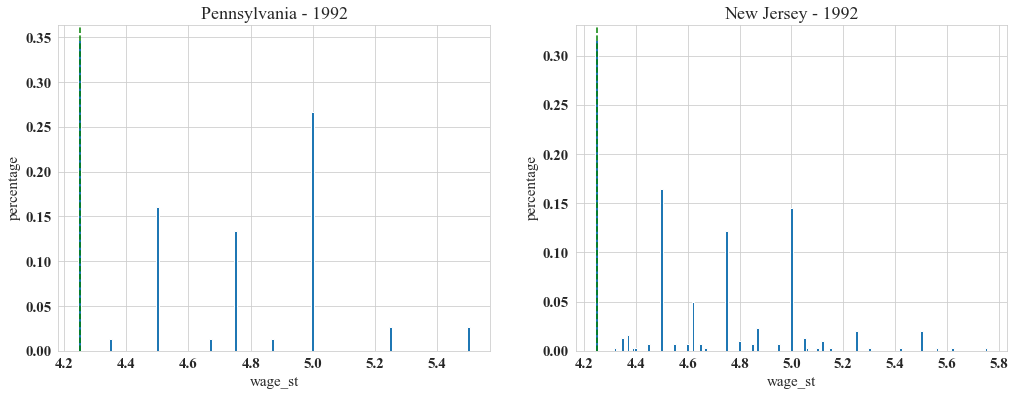

In [135]:
figure(num=None, figsize=(17, 6))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)



# Draw first subplot using plt.subplot
plt.subplot(1, 2, 1)
plt.bar(graph1_PA["wage_st"], graph1_PA["percentage"],width = 0.01)
plt.title('Pennsylvania - 1992')
plt.xlabel('wage_st')
plt.ylabel('percentage')
plt.axvline(4.25, 0, color = "green", linestyle = "--")

# Draw second subplot using plt.subplot
plt.subplot(1, 2, 2)
plt.bar(graph1_NJ["wage_st"], graph1_NJ["percentage"],width = 0.01)
plt.title('New Jersey - 1992')
plt.xlabel('wage_st')
plt.ylabel('percentage')
plt.axvline(4.25, 0, color = "green", linestyle = "--");




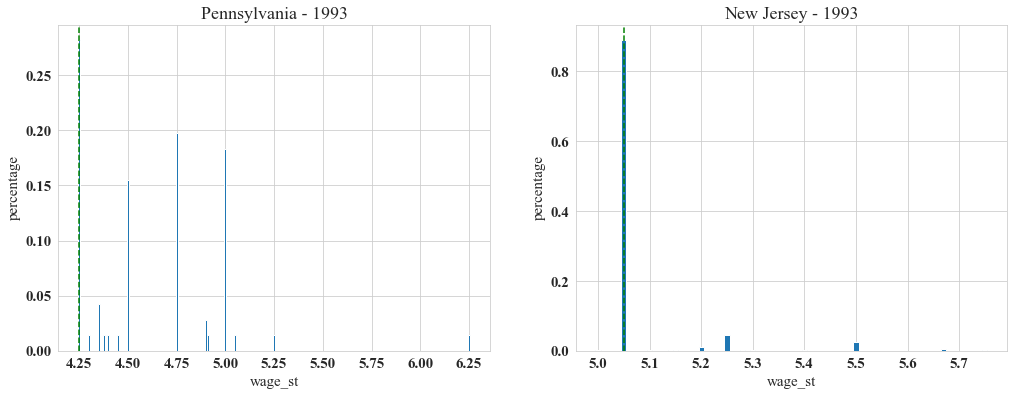

In [132]:
figure(num=None, figsize=(17, 6))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)



# Draw first subplot using plt.subplot
plt.subplot(1, 2, 1)
plt.bar(graph2_PA["wage_st"], graph2_PA["percentage"],width = 0.01)
plt.title('Pennsylvania - 1993')
plt.xlabel('wage_st')
plt.ylabel('percentage')
plt.axvline(4.25, 0, color = "green", linestyle = "--")

# Draw second subplot using plt.subplot
plt.subplot(1, 2, 2)
plt.bar(graph2_NJ["wage_st"], graph2_NJ["percentage"],width = 0.01)
plt.title('New Jersey - 1993')
plt.xlabel('wage_st')
plt.ylabel('percentage')
plt.axvline(5.05, 0, color = "green", linestyle = "--");



In [34]:
a = round(graph1_PA["wage_st"].mean(),2)
b = round(graph1_NJ["wage_st"].mean(),2)

c = round(graph2_PA["wage_st"].mean(),2)
d = round(graph2_NJ["wage_st"].mean(),2)

print("The minimum wage in Pennsylvania in 1992 was {} and in New Jersey {}. In 1993, after the minimum wage increase in NJ, in PA the minimum wage was {} and in NJ {}. Wages increased in NJ!".format(a, b, c, d))


The minimum wage in Pennsylvania in 1992 was 4.79 and in New Jersey 4.88. In 1993, after the minimum wage increase in NJ, in PA the minimum wage was 4.77 and in NJ 5.29. Wages increased in NJ!


<font size="3">**4.2 Welch’s t-test of equlity of means**</font>


The first step is to analyze the key variables from a descriptive perspective. We will focus exclusively on the following four variables: 
- FTE employment
- starting wage
- price of full meal 
- hours open

For each variable, we perform a test of equality of means between the two states both before and after the reform. 

We want to answer this question: Which variables are statistically different (5% level) between the two states in wave 1? And in wave 2? We will discuss whether these differences are a threat to validity in the DiD framework.

In [35]:
# We compute the means of the 4 variables for each state in each period

# WAVE 1

## PA
fte_emp_1PA = round(data_PA_before["fte_emp"].dropna().mean(),3) 
wage_st_1PA = round(data_PA_before["wage_st"].dropna().mean(),3) 
price_full_1PA = round(data_PA_before["fullmeal"].dropna().mean(),3) 
hrsopen_1PA = round(data_PA_before["hrsopen"].dropna().mean(),3) 

## NJ
fte_emp_1NJ = round(data_NJ_before["fte_emp"].dropna().mean(),3) 
wage_st_1NJ = round(data_NJ_before["wage_st"].dropna().mean(),3) 
price_full_1NJ = round(data_NJ_before["fullmeal"].dropna().mean(),3) 
hrsopen_1NJ = round(data_NJ_before["hrsopen"].dropna().mean(),3) 


# WAVE 2

## PA
fte_emp_2PA = round(data_PA_after["fte_emp"].dropna().mean(),3) 
wage_st_2PA = round(data_PA_after["wage_st"].dropna().mean(),3) 
price_full_2PA = round(data_PA_after["fullmeal"].dropna().mean(),3) 
hrsopen_2PA = round(data_PA_after["hrsopen"].dropna().mean(),3) 

## NJ
fte_emp_2NJ = round(data_NJ_after["fte_emp"].dropna().mean(),3) 
wage_st_2NJ = round(data_NJ_after["wage_st"].dropna().mean(),3) 
price_full_2NJ = round(data_NJ_after["fullmeal"].dropna().mean(),3) 
hrsopen_2NJ = round(data_NJ_after["hrsopen"].dropna().mean(),3) 


print("\033[1m" + "Wave 1" + "\033[0m")
print(pd.DataFrame({
  "state": ["Pennsylvania", "New Jersey"],
  "fte": [fte_emp_1PA, fte_emp_1NJ],
    "wage_st": [wage_st_1PA,wage_st_1NJ],
    "fullmeal": [price_full_1PA,price_full_1NJ],
    "hrsopen": [hrsopen_1PA,hrsopen_1NJ]
}))
print("")
print("")
print("\033[1m" + "Wave 2" + "\033[0m")
print(pd.DataFrame({
  "state": ["Pennsylvania", "New Jersey"],
  "fte": [fte_emp_2PA, fte_emp_2NJ],
    "wage_st": [wage_st_2PA,wage_st_2NJ],
    "fullmeal": [price_full_2PA,price_full_2NJ],
    "hrsopen": [hrsopen_2PA,hrsopen_2NJ]
}))

Wave 1
          state     fte  wage_st  fullmeal  hrsopen
0  Pennsylvania  23.395    4.632     3.044   14.545
1    New Jersey  20.595    4.614     3.362   14.419


Wave 2
          state     fte  wage_st  fullmeal  hrsopen
0  Pennsylvania  21.444    4.617     3.027   14.654
1    New Jersey  21.362    5.081     3.417   14.415


Are the differences in means statistically significant at the 5% level?

useful website: [here](https://docs.scipy.org/doc/scipy/reference/stats.html)

In [36]:
# WAVE 1
print(stats.ttest_ind(data_PA_before["fte_emp"], data_NJ_before["fte_emp"], nan_policy = "omit", equal_var = "False"))

print(stats.ttest_ind(data_PA_before["wage_st"], data_NJ_before["wage_st"], nan_policy = "omit", equal_var = "False"))

print(stats.ttest_ind(data_PA_before["fullmeal"], data_NJ_before["fullmeal"], nan_policy = "omit", equal_var = "False"))

print(stats.ttest_ind(data_PA_before["hrsopen"], data_NJ_before["hrsopen"], nan_policy = "omit", equal_var = "False"))

print("")
# WAVE 2
print(stats.ttest_ind(data_PA_after["fte_emp"], data_NJ_after["fte_emp"], nan_policy = "omit", equal_var = "False"))

print(stats.ttest_ind(data_PA_after["wage_st"], data_NJ_after["wage_st"], nan_policy = "omit", equal_var = "False"))

print(stats.ttest_ind(data_PA_after["fullmeal"], data_NJ_after["fullmeal"], nan_policy = "omit", equal_var = "False"))

print(stats.ttest_ind(data_PA_after["hrsopen"], data_NJ_after["hrsopen"], nan_policy = "omit", equal_var = "False"))



Ttest_indResult(statistic=2.245247013658953, pvalue=0.025319182028094432)
Ttest_indResult(statistic=0.39726357282288066, pvalue=0.6913979207850036)
Ttest_indResult(statistic=-3.841252125162487, pvalue=0.0001437528830678993)
Ttest_indResult(statistic=0.35241163571922846, pvalue=0.7247165854570804)

Ttest_indResult(statistic=0.07282264623872245, pvalue=0.9419847745940799)
Ttest_indResult(statistic=-19.687920950541287, pvalue=3.044042697301196e-60)
Ttest_indResult(statistic=-4.74972335928515, pvalue=2.910374550442637e-06)
Ttest_indResult(statistic=0.686579699803257, pvalue=0.4927494500351133)


We summarise our finding in the [following table](https://helgone.github.io/ProForQ/#theory3.3) on the companion website.

<font size="3">**4.3 DiD estimation**</font>

In [37]:
data["state"].astype("category") # be sure which one is the reference group in the regression we will run (we set PA before)

0        New Jersey
1        New Jersey
2        New Jersey
3        New Jersey
4        New Jersey
           ...     
793    Pennsylvania
794    Pennsylvania
795    Pennsylvania
796    Pennsylvania
797    Pennsylvania
Name: state, Length: 798, dtype: category
Categories (2, object): [Pennsylvania < New Jersey]

In [38]:
model_interaction = smf.ols(formula='fte_emp ~ state + after + state:after', data=data).fit()

summary = model_interaction.get_robustcov_results(cov_type='HC1', use_t=True).summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,23.3947,1.362,17.177,0.000,20.721,26.068
state[T.New Jersey],-2.7997,1.457,-1.921,0.055,-5.661,0.061
after,-1.9507,1.638,-1.191,0.234,-5.166,1.264
state[T.New Jersey]:after,2.7179,1.791,1.517,0.130,-0.798,6.234


The effect is 2.718 (1.791) , not significant.

<font size="5">**5 Regression Discontinuity Design**</font>

The academic paper which results we will replicate is: 

**Douglas Almond, Joseph Doyle, Amanda Kowalski, and Heidi Williams (2010). Estimating marginal returns to
medical care: Evidence from at-risk newborns. Quarterly Journal of Economics, 125 (2): 591-634.**
This section is divided as follows:
- **5.1** Creating all necessary variables
- **5.2** Graphical analysis
- **5.3** RDD estimation
- **5.4** Specification checks
    - Vary the bandwidth
    - Allow for a quadratic functional form of the running variable
    - Compute the symmetric and asymmetric optimal bandwidths
- **5.5** Discussion about identification strategy of the authors

<font size="3">**5.1 Creating all necessary variables**</font> 

In [55]:
data = pd.read_csv("data/Almond_Etal_QJE_2010_data.csv")

In [56]:
data

,dbirwt,death1year
0,1503,0
1,1503,0
2,1503,0
3,1503,0
4,1503,0
...,...,...
202066,1418,0
202067,1418,0
202068,1418,0
202069,1418,0


In [66]:
data["dbirwt_centered"]  = data["dbirwt"] - 1500
data["dbirwt_centered2"] = data["dbirwt_centered"]*data["dbirwt_centered"]
data["VLBW"]             = np.where(data["dbirwt"] < 1500, 1, 0)

<font size="3">**5.2 Graphical analysis**</font>

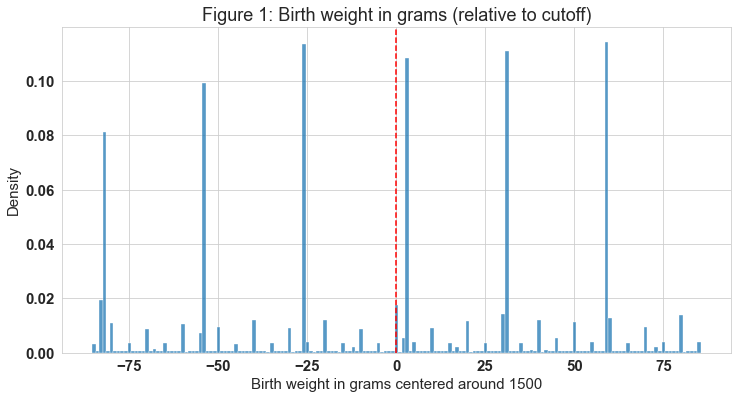

In [131]:
# Density Graph
sns.histplot(data=data, x="dbirwt_centered", stat="probability", discrete=True)
plt.axvline(0, 0, color = "red", linestyle = "--")
plt.xlabel('Birth weight in grams centered around 1500')
plt.ylabel("Density")
plt.title("Figure 1: Birth weight in grams (relative to cutoff)");


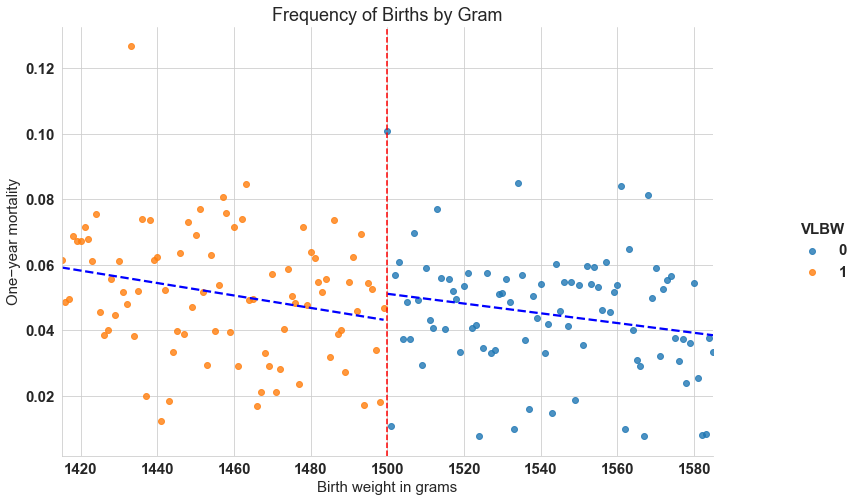

In [130]:
# RDD Graph

# necessary dataset
dataRDD_graph = pd.DataFrame(data.groupby(["dbirwt", "VLBW"])["death1year"].mean()).reset_index()

# plot the data
sns.lmplot(x="dbirwt", y="death1year", hue="VLBW", data=dataRDD_graph, ci = None, line_kws={'color': 'blue', 'linestyle' : "--"}).fig.set_size_inches(13,7)           
plt.title("Frequency of Births by Gram")
plt.ylabel("One−year mortality")
plt.xlabel('Birth weight in grams')
plt.axvline(1500, 0, color = "red", linestyle = "--")
sns.set_style("whitegrid");





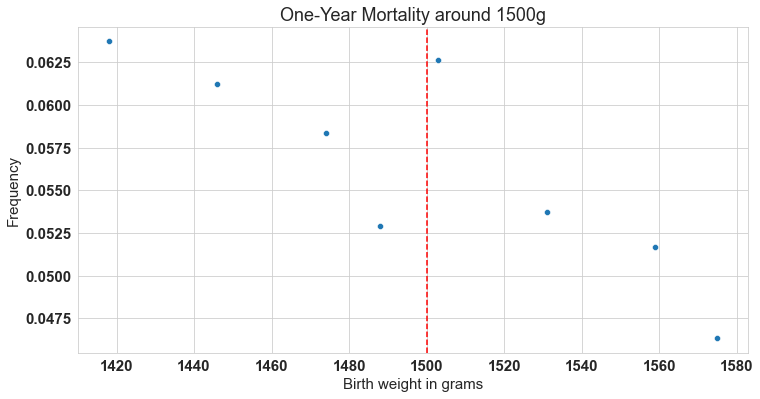

In [129]:
# another strategy (employed by the authors) to visualize the discontinuity, is to divide the data in bins (based on grams) and plot the median of each bin

mybin = pd.cut(data["dbirwt"], bins=8, include_lowest = True, right=False)

data["bins"] = mybin


data_graph2 = data.groupby(["bins"]).agg(
    
    median_dbirwt = pd.NamedAgg(column = "dbirwt", aggfunc = "median"),
    mean_death1year = pd.NamedAgg(column = "death1year", aggfunc = "mean")
)

             
           
 
sns.scatterplot(data=data_graph2, x="median_dbirwt", y="mean_death1year") 
plt.title("One-Year Mortality around 1500g")
plt.ylabel("Frequency")
plt.xlabel('Birth weight in grams')
plt.axvline(1500, 0, color = "red", linestyle = "--");



<font size="3">**5.3 RDD estimation**</font>

In [64]:
print(data)

        dbirwt  death1year  dbirwt_centered  dbirwt_centered2  VLBW  \
0         1503           0                3                 9     0   
1         1503           0                3                 9     0   
2         1503           0                3                 9     0   
3         1503           0                3                 9     0   
4         1503           0                3                 9     0   
...        ...         ...              ...               ...   ...   
202066    1418           0              -82              6724     1   
202067    1418           0              -82              6724     1   
202068    1418           0              -82              6724     1   
202069    1418           0              -82              6724     1   
202070    1417           0              -83              6889     1   

        interaction  interaction2               bins  
0                 0             0  [1500.0, 1521.25)  
1                 0             0  [1

In [80]:
rdd_ols = smf.ols(formula="death1year ~ VLBW + dbirwt_centered + VLBW:dbirwt_centered", data=data).fit(
    cov_type='cluster',
              cov_kwds={'groups': data["dbirwt"]},use_t=True)

rdd_ols.summary()


#tble = summary_col(rdd_ols, stars = True) #, regressor_order=regressors)

#tble.tables[0] = tble.tables[0][:9]
#print(tble)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             death1year   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.627
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           6.64e-06
Time:                        15:43:16   Log-Likelihood:                 7528.5
No. Observations:              202071   AIC:                        -1.505e+04
Df Residuals:                  202067   BIC:                        -1.501e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0631      0.004     15.938      0.000       0.055       0.071
VLBW                    -0.0095      0.005     -2.002      0.047      -0.019      -0.000
dbirwt_centered         -0.0002   8.07e-05     -2.774      0.006      -0.000   -6.46e-05
VLBW:dbirwt_centered  8.744e-05      0.000      0.860      0.391      -0.000       0.000
==============================================================================
Omnibus:                   151976.870   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1774170.299
Skew:                           3.791   Prob(JB):                         0.00
Kurtosis:                      15.379   Cond. No.                         259.
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

<font size="3">**5.3 Specification checks**</font> 

In [83]:
# Use a 25-grams bandwidth around the cutoff ("zoom closer")


data25 = data.loc[(data.dbirwt_centered).abs() <= 25]


rdd_ols = smf.ols(formula="death1year ~ VLBW + dbirwt_centered + VLBW:dbirwt_centered", data=data25).fit(
    cov_type='cluster',
              cov_kwds={'groups': data25["dbirwt"]},use_t=True)

rdd_ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             death1year   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.700
Date:                Mon, 07 Jun 2021   Prob (F-statistic):             0.0555
Time:                        15:49:09   Log-Likelihood:                 910.22
No. Observations:               44489   AIC:                            -1812.
Df Residuals:                   44485   BIC:                            -1778.
Df Model:                           3                                         
Covariance Type:              cluster                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0693      0.007      9.807      0.000       0.055       0.083
VLBW                    -0.0250      0.009     -2.766      0.008      -0.043      -0.007
dbirwt_centered         -0.0013      0.001     -2.354      0.023      -0.002      -0.000
VLBW:dbirwt_centered     0.0008      0.001      1.083      0.284      -0.001       0.002
==============================================================================
Omnibus:                    32746.947   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           357157.870
Skew:                           3.704   Prob(JB):                         0.00
Kurtosis:                      14.739   Cond. No.                         67.1
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [88]:
# allow for a quadratic functional form

rdd_ols = smf.ols(formula="death1year ~ VLBW + dbirwt_centered + VLBW:dbirwt_centered + dbirwt_centered2  + VLBW:dbirwt_centered2", data=data).fit(    
    cov_type='cluster',
              cov_kwds={'groups': data["dbirwt"]},use_t=True)

rdd_ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             death1year   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.541
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           2.03e-06
Time:                        16:03:52   Log-Likelihood:                 7533.0
No. Observations:              202071   AIC:                        -1.505e+04
Df Residuals:                  202065   BIC:                        -1.499e+04
Df Model:                           5                                         
Covariance Type:              cluster                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0655      0.006     10.948      0.000       0.054       0.077
VLBW                     -0.0160      0.008     -2.113      0.036      -0.031      -0.001
dbirwt_centered          -0.0005      0.000     -1.603      0.111      -0.001       0.000
VLBW:dbirwt_centered      0.0001      0.000      0.356      0.722      -0.001       0.001
dbirwt_centered2       3.629e-06    3.3e-06      1.100      0.273   -2.88e-06    1.01e-05
VLBW:dbirwt_centered2 -5.687e-06   4.32e-06     -1.318      0.189   -1.42e-05    2.83e-06
==============================================================================
Omnibus:                   151968.854   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1773895.927
Skew:                           3.791   Prob(JB):                         0.00
Kurtosis:                      15.378   Cond. No.                     3.10e+04
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 3.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
# pip install rdd

from rdd import rdd
# optimal bandwidth
bandwidth_opt = rdd.optimal_bandwidth(data["death1year"], data["dbirwt_centered"], cut=0)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 0.8759586892057302


In [93]:
?rdd.optimal_bandwidth

<font size="5">**6 Instrumental Variables**</font>

The academic paper which results we will replicate is: 

**Angrist, Joshua D & Krueger, Alan B, 1991. Does Compulsory School Attendance Affect Schooling and Earnings? *The Quarterly Journal of Economics*, vol. 106(4), pages 979-1014.**
This section is divided as follows:
- **6.1** 
- **6.2** 
- **6.3** 
- **6.4** 
    - Vary the bandwidth
    - Allow for a quadratic functional form of the running variable
    - Compute the symmetric and asymmetric optimal bandwidths
- **6.5** Discussion about identification strategy of the authors

In [205]:
data = pd.read_csv("data/Angrist_Krueger_QJE_1991_data.csv")
data["SMSA"] = np.where(data["SMSA"] == 1, 0, 1) # in the data, it is wrongly inverted
data.head()

,Unnamed: 0,YOB,QOB,AGEQ,AGEQSQ,EDUC,LWKLYWGE,MARRIED,RACE,SMSA,ENOCENT,ESOCENT,MIDATL,MT,NEWENG,SOATL,WNOCENT,WSOCENT,quarter
0,1,33,1,47.00,2209.0000,12,6.245846,1,1,0,0,0,0,0,0,0,0,0,1
1,2,33,4,46.25,2139.0625,12,5.847161,1,1,0,0,0,0,0,0,0,0,0,0
2,3,30,1,50.00,2500.0000,12,6.645516,1,1,0,0,0,0,0,0,0,0,0,1
3,4,33,1,47.00,2209.0000,16,6.706133,1,1,0,0,0,0,0,0,0,0,0,1
4,5,37,4,42.25,1785.0625,14,6.357876,1,1,0,0,0,0,0,0,0,0,0,0


In [209]:
graph_data = (data
              .groupby(["YOB", "QOB"])
              [["LWKLYWGE", "EDUC"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: 1900 + d["YOB"] + (d["QOB"])/4))


graph_data["time_of_birth"] = graph_data["time_of_birth"].apply(lambda x: x -0.25)
graph_data.head()

,YOB,QOB,LWKLYWGE,EDUC,time_of_birth
0,30,1,5.889133,12.280405,1930.00
1,30,2,5.898007,12.428418,1930.25
2,30,3,5.909365,12.491860,1930.50
3,30,4,5.914354,12.624675,1930.75
4,31,1,5.902136,12.540434,1931.00


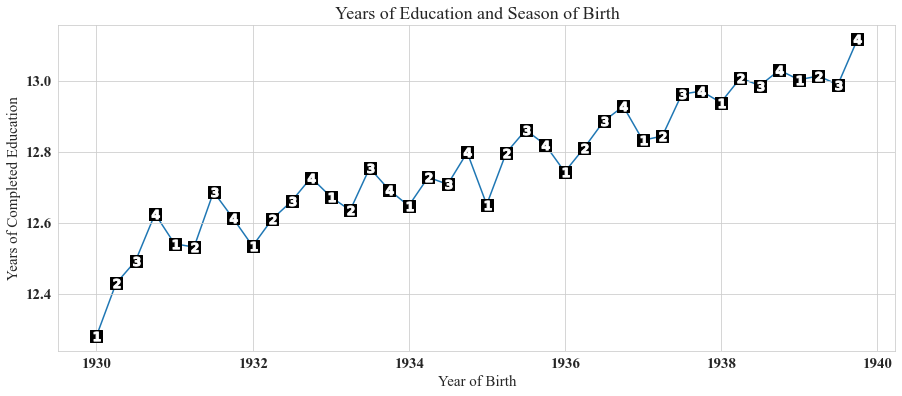

In [210]:
plt.figure(figsize=(15,6))
plt.plot(graph_data["time_of_birth"], graph_data["EDUC"], zorder=-1)


for i in range(1, 5):
    x = graph_data.query(f"QOB=={i}")["time_of_birth"]
    y = graph_data.query(f"QOB=={i}")["EDUC"]
    plt.scatter(x, y, marker="s",c = "black", s=160) # c=f"C{i}"
    plt.scatter(x, y, marker=f"${i}$", s=85, c=f"white")
    

plt.title("Years of Education and Season of Birth")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Completed Education");

In [49]:
def my_ols(x,y):
    return np.dot(np.dot(np.lialg.inv(np.dot(x.T, x)), x.T), y)

def my_iv(x, y, inst):
    return np.dot(np.dot(np.linalg.inv(np.dot(inst.T, x)), inst.T), y)

<font size="3">**6.2 Simulation**</font> 

Assume the following parameter values: 
- $\alpha$ = 25.0.
- $\beta$ = 1.0.
- $\sigma_u$ = 10.0.
- $\sigma_e$ = 0.1.
- $\gamma$ = 10.0.
- $\rho$ = 0.5.
- $z_i$ follows a unifrom distribution between 0.0 and 5.0.

In [50]:
# Define parameters
alpa = 25.0
beta = 1.0
sigma_u = 10.0
sigma_e = 0.1
gamma = 10.0
rho = 0.5
z_min = 0.0
z_max = 5.0
Nobs = 4000 # Number of observations every time we estimate beta
Nsim = 1000 # Number of times we estimate beta

# Store results
beta_OLS = []
beta_IV = []

for sim in range(Nsim):
    # Create Dataframe
    u = pd.Series(np.random.normal(0.0, sigma_u, Nobs))
    e = pd.Series(np.random.normal(0.0, sigma_e, Nobs))
    z = pd.Series(np.random.uniform(z_min, z_max, Nobs))

    df = pd.DataFrame({
    'u': u,
    'e': e,
    'z': z
    })
    df['x'] = gamma*df['z'] + rho*df['u'] + df['e']
    df['y'] = alpa + beta*df['x'] + df['u']
    df['constant'] = 1
    
    # Define model OLS
    MyModel = sm.OLS(endog = df['y'], 
                     exog = df[['constant', 'x']])
    
    # Safe estimate
    results = MyModel.fit()
    beta_OLS.append(results.params[1])
    
    # Define IV model
    iv = IV2SLS(dependent=df['y'],
            exog=df['constant'],
            endog=df['x'],
            instruments=df['z']).fit(cov_type='unadjusted')
    beta_IV.append(iv.params[1])

# Convert list to series
beta_OLS = pd.Series(beta_OLS)
beta_IV = pd.Series(beta_IV)

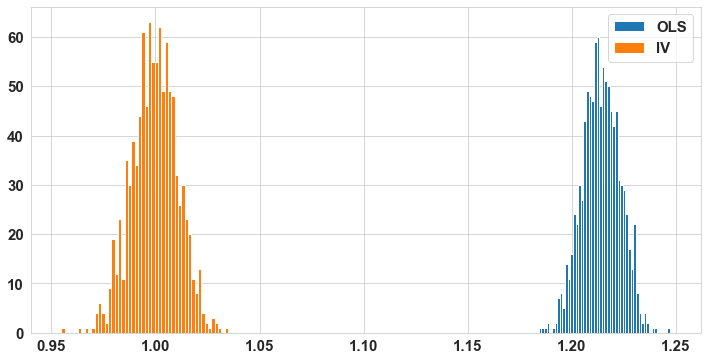

In [51]:
beta_OLS.hist(bins=50)
beta_IV.hist(bins=50)
plt.legend(['OLS','IV'])
plt.show()

In [52]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
# Load Data
df = px.data.tips()
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return px.scatter(
        df, x="total_bill", y="tip", color="size",
        color_continuous_scale=colorscale,
        render_mode="webgl", title="Tips"
    )
# Run app and display result inline in the notebook
app.run_server(mode='inline')

<font size="5">**6 Limitations of RCTs**</font>

- Deaton, Handbook pdf about RCTs. Understanding and misunderstanding randomized controlled trials
- Local Average Treatment Effects

<font size="5">**7 Conclusion and discussion**</font>

As part of this project, it has been created a GitHub website containing useful additional resoruces in connection with the topics of this document.


<font size="4">**List of examples for each topic:**</font>


- ◘ Nutrition
- ◘ Health
- ◘ Education: New York lottery to assign hosuing. But.. only people who signed up participated! Bias ?
- ◘ Labour Market: 
    - IV same sex and siblings: Heterugonous IV + characteristics compliers
    - Kard Kruger: Quantile
- ◘ Political Economy
    - Acemoglu
- ◘ Family
- ◘ Savings
    - *Macro III* ? Could explain endogenous growth models?
    - Then some empirical papers

In [53]:
# USELESS

data_before.groupby(["state","wage_st"])


a = pd.DataFrame(data_before.groupby(['state','wage_st']).size())
a

data_before.groupby(['state','wage_st']).size()["Pennsylvania"][4:10]


# how many observations are there in each state?

data_before.groupby("state").size()["Pennsylvania"] # 78
data_before.groupby("state").size()["New Jersey"] # 321


a = pd.DataFrame(data_before.groupby(['state','wage_st']).size())
a


data_before.groupby(['state','wage_st']).size()["New Jersey"]

wage_st
4.25    96
4.32     1
4.35     4
4.37     5
4.39     1
4.40     1
4.45     2
4.50    50
4.55     2
4.60     2
4.62    15
4.65     2
4.67     1
4.75    37
4.80     3
4.85     2
4.87     7
4.95     2
5.00    44
5.05     4
5.06     1
5.10     1
5.12     3
5.15     1
5.25     6
5.30     1
5.42     1
5.50     6
5.56     1
5.62     1
5.75     1
dtype: int64